#**Intelligent Recommendor System Based on Textual Content**

**Objective**:
Provide a great user experience for students on Xloosv app (private social communication platform) by predicting most interesting posts!

**Focus**: choose the best feature engineering techniques or implement a new one that could improve the accuracy. 

**plan**:
1.  Predict the best posts (Part 1):

  - predict the number of upvotes a post will receive based on its textual content (NLP) and store it in a "NLP score" variable
  - use Elasticsearch Decay Function to predict the best 10 posts to show based on:

      1. creation Date
      2. number of likes
      3. number of comments
      4. NLP score

2. predict the hashtag/topic/subreddit of a post based on its textual content (Part 2)

Other possible tasks:

  * Merge the models to the Xloosv app using Firebase ML then make it continue learning and improving from future data
  * repeat the previous tasks, but based on image content (for posts that contain images)

**Dataset**:  

A large collection of Reddit posts:
- https://github.com/umbrae/reddit-top-2.5-million/
- https://www.kaggle.com/unanimad/dataisbeautiful




# **Importing data & libraries**

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
path = "/content/drive/MyDrive/Senior Project/Reddit_Posts.csv"
df = pd.read_csv(path)
print(df)

            id  ... over_18
0       ll1p9h  ...   False
1       ll1o4h  ...   False
2       ll15gx  ...   False
3       ll0iup  ...   False
4       ll0g9a  ...   False
...        ...  ...     ...
190848   pqbdl  ...   False
190849   pqav2  ...   False
190850   pq922  ...   False
190851   ppx09  ...   False
190852   ppvl7  ...   False

[190853 rows x 12 columns]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Data visualization & preprocessing

In [25]:
df.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll1p9h,Wordcloud of trending video titles on YouTube ...,1,OmarZiada,OC: 1,NaN,0.0,[],1613473961,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,ll1o4h,Wordcloud of trending videos on YouTube in the...,1,OmarZiada,OC: 1,moderator,0.0,[],1613473829,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,ll15gx,Immunization in India. Source: https://niti.go...,1,Professional_Napper_,NaN,moderator,0.0,[],1613471541,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,ll0iup,How to quickly estimate the impact of players ...,1,Viziball,NaN,automod_filtered,0.0,[],1613468624,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,ll0g9a,How to quickly estimate the impact of players ...,1,Viziball,NaN,moderator,0.0,[],1613468281,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


In [26]:
# Checking for 'Nan' values if any
df.isna().sum()

id                            0
title                         1
score                         0
author                        0
author_flair_text        162008
removed_by               170109
total_awards_received    125707
awarders                 136375
created_utc                   0
full_link                     0
num_comments                  0
over_18                       0
dtype: int64

In [27]:
# Delete columns that are not needed
del df['author_flair_text']
del df['removed_by']
del df['total_awards_received']
del df['awarders']
del df['id']
del df['created_utc']
del df['full_link']
del df['over_18']
del df['author']

In [28]:
df.head()

,title,score,num_comments
0,Wordcloud of trending video titles on YouTube ...,1,0
1,Wordcloud of trending videos on YouTube in the...,1,1
2,Immunization in India. Source: https://niti.go...,1,1
3,How to quickly estimate the impact of players ...,1,0
4,How to quickly estimate the impact of players ...,1,2


In [29]:
df.shape

(190853, 3)

In [30]:
# replace na with empty string
df.title.fillna(" ",inplace = True)

In [31]:
# Return a Series containing counts of unique values of titles.
df.title.value_counts()

data_irl                                                                                       1058
Data_irl                                                                                        360
裕美･ルミィヤンツェヴァのスライドショー                                                                            262
Title your visualization but keep the closing tag [OC]                                          111
Dataviz Open Discussion Thread for /r/dataisbeautiful                                            87
                                                                                               ... 
What Americans thought of Jewish refugees on the eve of World War II                              1
Similarity clusters of all Elon Musk, Donald Trump and Barack Obama tweets (PCA, UMAP) [OC]       1
15 most countries by Oil production                                                               1
Analyzing Lebron James’ Offensive Play                                                            1


# **Part A: trainning custom Word2vec model**

## Word2vec

Using Gensim library

In [32]:
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import re  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [33]:
# make sure the data is clean
df.isnull().sum()

title           0
score           0
num_comments    0
dtype: int64

###bigrams

In [34]:
from gensim.models.phrases import Phrases, Phraser

In [35]:
sent = [row.split() for row in df['title']]

In [36]:
phrases = Phrases(sent, min_count=30, progress_per=20000)

INFO - 13:07:34: collecting all words and their counts
INFO - 13:07:34: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:07:35: PROGRESS: at sentence #20000, processed 249569 words and 153017 word types
INFO - 13:07:35: PROGRESS: at sentence #40000, processed 489662 words and 259626 word types
INFO - 13:07:36: PROGRESS: at sentence #60000, processed 716123 words and 361096 word types
INFO - 13:07:36: PROGRESS: at sentence #80000, processed 923474 words and 447861 word types
INFO - 13:07:37: PROGRESS: at sentence #100000, processed 1143779 words and 544389 word types
INFO - 13:07:37: PROGRESS: at sentence #120000, processed 1338389 words and 639220 word types
INFO - 13:07:38: PROGRESS: at sentence #140000, processed 1533932 words and 734679 word types
INFO - 13:07:38: PROGRESS: at sentence #160000, processed 1728263 words and 825600 word types
INFO - 13:07:39: PROGRESS: at sentence #180000, processed 1925157 words and 912882 word types
INFO - 13:07:39: collected 95

In [37]:
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 13:07:39: source_vocab length 958910
INFO - 13:07:49: Phraser built with 1268 phrasegrams


In [38]:
sentences

In [39]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

168870

###Train the titles column

In [40]:
import multiprocessing

from gensim.models import Word2Vec

In [41]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [42]:
# 1-setup
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [43]:
# 2-building vocabulary
w2v_model.build_vocab(sentences, progress_per=100000)

INFO - 13:07:56: collecting all words and their counts
INFO - 13:07:56: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:08:01: PROGRESS: at sentence #100000, processed 1072020 words, keeping 99282 word types
INFO - 13:08:04: collected 168870 word types from a corpus of 1918928 raw words and 190853 sentences
INFO - 13:08:04: Loading a fresh vocabulary
INFO - 13:08:04: effective_min_count=10 retains 17133 unique words (10% of original 168870, drops 151737)
INFO - 13:08:04: effective_min_count=10 leaves 1635883 word corpus (85% of original 1918928, drops 283045)
INFO - 13:08:04: deleting the raw counts dictionary of 168870 items
INFO - 13:08:04: sample=6e-05 downsamples 806 most-common words
INFO - 13:08:04: downsampling leaves estimated 969457 word corpus (59.3% of prior 1635883)
INFO - 13:08:04: estimated required memory for 17133 words and 300 dimensions: 49685700 bytes
INFO - 13:08:04: resetting layer weights


In [44]:
# 3-trainning the model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1, report_delay=1)

INFO - 13:08:09: training model with 1 workers on 17133 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:08:10: EPOCH 1 - PROGRESS: at 5.31% examples, 56112 words/s, in_qsize 2, out_qsize 0
INFO - 13:08:11: EPOCH 1 - PROGRESS: at 11.23% examples, 60084 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:12: EPOCH 1 - PROGRESS: at 17.39% examples, 61638 words/s, in_qsize 2, out_qsize 0
INFO - 13:08:13: EPOCH 1 - PROGRESS: at 23.46% examples, 62518 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:14: EPOCH 1 - PROGRESS: at 29.83% examples, 62374 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:15: EPOCH 1 - PROGRESS: at 37.02% examples, 62361 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:16: EPOCH 1 - PROGRESS: at 43.67% examples, 62593 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:17: EPOCH 1 - PROGRESS: at 50.25% examples, 62500 words/s, in_qsize 1, out_qsize 0
INFO - 13:08:18: EPOCH 1 - PROGRESS: at 56.97% examples, 62527 words/s, in_qsize 1, out_qsize 0
IN

(969382, 1918928)

In [45]:
w2v_model.wv.most_similar(positive=["music"])

INFO - 13:08:24: precomputing L2-norms of word weight vectors


[('covid-19', 0.9999669790267944),
 ('2020)', 0.9999659657478333),
 ('\u200d_\u200d', 0.9999648928642273),
 ('Wuhan', 0.9999648332595825),
 ("I'm_building", 0.99996417760849),
 ('Reviews_-', 0.9999641180038452),
 ('alongside', 0.9999641180038452),
 ('coronavirus', 0.9999641180038452),
 ('COVID', 0.9999639987945557),
 ('Cab_|', 0.9999638795852661)]

In [46]:
w2v_model.wv.most_similar(positive=["bad"])

[('2020)', 0.9999748468399048),
 ('Reviews_-', 0.9999746084213257),
 ('Buy', 0.9999743700027466),
 ('covid', 0.9999738931655884),
 ('Biden', 0.9999737739562988),
 ('2020.', 0.9999733567237854),
 ('2020,', 0.999972939491272),
 ('COVID', 0.9999727010726929),
 ('infections', 0.9999725818634033),
 ('-_2020)', 0.9999724626541138)]

In [47]:
w2v_model.wv.most_similar(positive=['covid'])

[('COVID', 0.9999861717224121),
 ('\u200d_\u200d', 0.9999860525131226),
 ('Biden', 0.9999860525131226),
 ('Buy', 0.999985933303833),
 ('Reviews_-', 0.9999853372573853),
 ('covid-19', 0.9999850392341614),
 ('COVID19', 0.9999840259552002),
 ('2020.', 0.9999837875366211),
 ('2020)', 0.9999837875366211),
 ('coronavirus', 0.9999836683273315)]

In [48]:
w2v_model.vector_size

300

In [49]:
#calculating average word2vec
def get_avg_vec(words):
  # remove out-of-vocabulary words
  words = [word for word in words if word in w2v_model.wv.vocab]
  if len(words) >= 1:
      return np.mean(w2v_model[words], axis=0)
  else:
      return []

In [50]:
df['title'][0]

'Wordcloud of trending video titles on YouTube in the United States over 2017-2018 [OC]'

In [51]:
df['vector'] = df['title'].apply(get_avg_vec)
df['vector'][1].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

In [52]:
data = df
data

,title,score,num_comments,vector
0,Wordcloud of trending video titles on YouTube ...,1,0,"[0.11106304, -0.07197456, 0.10880342, 0.117878..."
1,Wordcloud of trending videos on YouTube in the...,1,1,"[0.11083746, -0.07174468, 0.10859103, 0.117533..."
2,Immunization in India. Source: https://niti.go...,1,1,"[0.12113535, -0.07834296, 0.11839711, 0.128730..."
3,How to quickly estimate the impact of players ...,1,0,"[0.10951812, -0.07075305, 0.10722663, 0.116707..."
4,How to quickly estimate the impact of players ...,1,2,"[0.10950344, -0.07068323, 0.10724188, 0.116696..."
...,...,...,...,...
190848,Infosthetics seems like it belongs here.,15,0,"[0.10991717, -0.07129385, 0.10787884, 0.117337..."
190849,Time lapse of every nuclear detonation from 19...,9,0,"[0.1157875, -0.07501139, 0.11351636, 0.1230055..."
190850,Wavii.,13,2,"[0.14967766, -0.09724118, 0.14592817, 0.159383..."
190851,An interactive representation of Pres. Obamas ...,21,0,"[0.10824224, -0.06996418, 0.10583362, 0.115014..."


In [53]:
data.shape

(190853, 4)

##***Train-test split***

In [54]:
data['score'] = data['score'].astype(int)
data = data[data['vector'].map(len) == 300]

data

INFO - 13:08:56: NumExpr defaulting to 2 threads.


,title,score,num_comments,vector
0,Wordcloud of trending video titles on YouTube ...,1,0,"[0.11106304, -0.07197456, 0.10880342, 0.117878..."
1,Wordcloud of trending videos on YouTube in the...,1,1,"[0.11083746, -0.07174468, 0.10859103, 0.117533..."
2,Immunization in India. Source: https://niti.go...,1,1,"[0.12113535, -0.07834296, 0.11839711, 0.128730..."
3,How to quickly estimate the impact of players ...,1,0,"[0.10951812, -0.07075305, 0.10722663, 0.116707..."
4,How to quickly estimate the impact of players ...,1,2,"[0.10950344, -0.07068323, 0.10724188, 0.116696..."
...,...,...,...,...
190848,Infosthetics seems like it belongs here.,15,0,"[0.10991717, -0.07129385, 0.10787884, 0.117337..."
190849,Time lapse of every nuclear detonation from 19...,9,0,"[0.1157875, -0.07501139, 0.11351636, 0.1230055..."
190850,Wavii.,13,2,"[0.14967766, -0.09724118, 0.14592817, 0.159383..."
190851,An interactive representation of Pres. Obamas ...,21,0,"[0.10824224, -0.06996418, 0.10583362, 0.115014..."


In [55]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3)

train

,title,score,num_comments,vector
172836,"[OC] County Names Added Up In Aggregate. ""Wash...",0,0,"[0.105400935, -0.067984015, 0.103060916, 0.112..."
162391,% Gameplay vs. Actual Time RATIOS - Hours Norm...,1,1,"[0.11284085, -0.07282765, 0.11043237, 0.119959..."
27628,[OC] https://www.who.int/,1,8,"[0.11068422, -0.07189218, 0.10826882, 0.118033..."
189935,I mapped my mouse input during 1 hour of reddi...,262,26,"[0.10605819, -0.068432525, 0.10396776, 0.11258..."
133628,Food Maps Around the World,1,1,"[0.089192346, -0.057014678, 0.0874881, 0.09426..."
...,...,...,...,...
51254,Incredible visualization of fire season weathe...,166,33,"[0.1086603, -0.070138656, 0.10620511, 0.115470..."
159774,Canada has the most overvalued housing market ...,5,2,"[0.103344075, -0.066605404, 0.1011264, 0.10983..."
90579,"[OC] Tinder success per 100 swipes, before and...",2,3,"[0.10555843, -0.068208, 0.103412144, 0.1125016..."
84459,Geese swimming in my yard during the flood.,1,1,"[0.10339207, -0.06682366, 0.1013818, 0.1097400..."


In [56]:
X_train = np.array(train['vector'].tolist())
y_train = np.array(train['score'])

X_test = np.array(test['vector'].tolist())
y_test = np.array(test['score'])

In [ ]:
y_train.shape

(133221,)

##**Modeling**

In [57]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

model_performance_dict = dict()

In [58]:
def r2_and_rmse(y_predicted):
    return [r2_score(y_test, y_predicted),np.sqrt(mean_squared_error(y_test, y_predicted))]

In [59]:
%%time
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

CPU times: user 729 µs, sys: 15 µs, total: 744 µs
Wall time: 772 µs


### Linear Regression

In [60]:
%%time
linear = LinearRegression()
linear.fit(X_train,y_train)

CPU times: user 3.83 s, sys: 367 ms, total: 4.2 s
Wall time: 2.52 s


In [61]:
y_predicted = linear.predict(X_test)
print(len(y_predicted))

57096


In [62]:
r2_and_rmse(y_predicted)

[0.0047439964892153075, 1984.2029846919693]

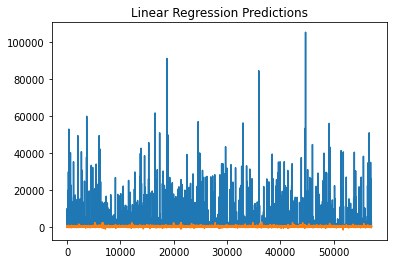

In [63]:
plt.title("Linear Regression Predictions")
plt.plot(range(57096), list(y_test), label='ground truth')
plt.plot(range(57096), list(y_predicted), label='Linear Regression')
plt.show()

### Random Forest

In [64]:
X_train = X_train[0:5000]
y_train = y_train[0:5000]

In [65]:
X_test = X_test[0:5000]
y_test = y_test[0:5000]

In [66]:
X_train.shape

(5000, 300)

In [67]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

RandomForestRegressor()

In [68]:
y_predicted = randomforest.predict(X_test)
print(len(y_predicted))

5000


In [69]:
r2_and_rmse(y_predicted)

[-0.04840628667004254, 2315.339498957746]

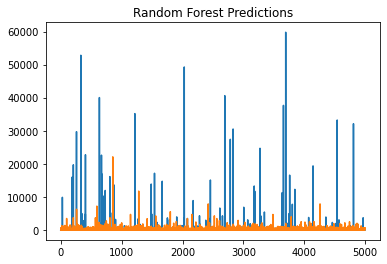

In [71]:
plt.title("Random Forest Predictions")
plt.plot(range(5000), list(y_test), label='ground truth')
plt.plot(range(5000), list(y_predicted), label='Random Forest')
plt.show()

### KNN 

In [72]:
knn_regression = KNeighborsRegressor()
knn_regression.fit(X_train, y_train)

KNeighborsRegressor()

In [76]:
y_predicted = knn_regression.predict(X_test)
print(len(y_predicted))

5000


In [77]:
r2_and_rmse(y_predicted)

[-0.052982234379794546, 2320.386844148191]

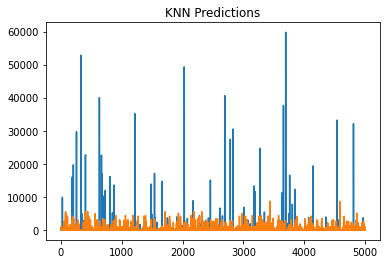

In [79]:
plt.title("KNN Predictions")
plt.plot(range(5000), list(y_test), label='ground truth')
plt.plot(range(5000), list(y_predicted), label='KNN')
plt.show()

### Neural Network (Deep Learning)

In [80]:
print(type(X_train))
X_train

<class 'numpy.ndarray'>


array([[ 0.10540093, -0.06798401,  0.10306092, ..., -0.03193859,
         0.03523285,  0.03046812],
       [ 0.11284085, -0.07282765,  0.11043237, ..., -0.03395812,
         0.03754792,  0.03252515],
       [ 0.11068422, -0.07189218,  0.10826882, ..., -0.03399025,
         0.03770616,  0.03186818],
       ...,
       [ 0.11060344, -0.07154981,  0.10811334, ..., -0.03335508,
         0.03710663,  0.03186364],
       [ 0.11036573, -0.07133881,  0.10814708, ..., -0.03338334,
         0.03703365,  0.03197423],
       [ 0.10732214, -0.06946351,  0.1049241 , ..., -0.03264348,
         0.03599223,  0.03094428]], dtype=float32)

In [81]:
print(len(X_train))
print(len(X_train[0]))

5000
300


In [82]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Conv1D, Dense, MaxPooling1D, Activation, Embedding, Dropout

nnmodel = Sequential()

nnmodel.add(Embedding(1000, 64, input_length=300))

nnmodel.add(MaxPooling1D())

#nnmodel.add(Conv1D(filters = 32, kernel_size = (3),padding = 'Same',activation ='relu', input_shape = (1, 300, 1)))
nnmodel.add(Dense(64))

nnmodel.add(Dropout(0.5))

#nnmodel.add(Conv1D(filters = 64, kernel_size = (3),padding = 'Same',activation ='relu'))

nnmodel.add(Flatten())
nnmodel.add(Dense(256))
nnmodel.add(Activation('relu'))
nnmodel.add(Dense(1, activation = "linear"))
    

nnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           64000     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 64)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 150, 64)           4160      
                                                                 
 dropout (Dropout)           (None, 150, 64)           0         
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2457856   
                                                        

In [83]:
import tensorflow as tf

nnmodel.compile(loss='MSE',
             optimizer='adam',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [84]:
history = nnmodel.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
157/157 [==============================] - 7s 39ms/step - loss: 2182162.7500 - root_mean_squared_error: 1477.2145
Epoch 2/10
157/157 [==============================] - 6s 38ms/step - loss: 2182141.5000 - root_mean_squared_error: 1477.2073
Epoch 3/10
157/157 [==============================] - 6s 38ms/step - loss: 2179630.5000 - root_mean_squared_error: 1476.3572
Epoch 4/10
157/157 [==============================] - 6s 38ms/step - loss: 2180696.5000 - root_mean_squared_error: 1476.7181
Epoch 5/10
157/157 [==============================] - 6s 38ms/step - loss: 2179489.2500 - root_mean_squared_error: 1476.3093
Epoch 6/10
157/157 [==============================] - 6s 39ms/step - loss: 2181649.5000 - root_mean_squared_error: 1477.0408
Epoch 7/10
157/157 [==============================] - 6s 39ms/step - loss: 2179523.2500 - root_mean_squared_error: 1476.3208
Epoch 8/10
157/157 [==============================] - 6s 38ms/step - loss: 2179336.5000 - root_mean_squared_error: 1476.2576


Loss on last epoch:  2178417.75


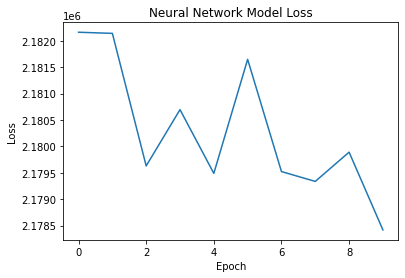

In [85]:
plt.title("Neural Network Model Loss")
plt.plot(history.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
print("Loss on last epoch: ", history.history['loss'][9])

In [86]:
y_predicted = nnmodel.predict(X_test)

In [87]:
r2_and_rmse(y_predicted)

[-3.2730416155146713e-09, 2261.2567341638905]

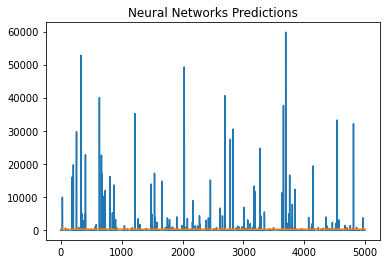

In [89]:
plt.title("Neural Networks Predictions")
plt.plot(range(5000), list(y_test), label='ground truth')
plt.plot(range(5000), list(y_predicted), label='Neural Network')
plt.show()

# **Part B: pre-trained Word2vec model**

## Pre-trained Word2vec

Load pre-trained word2vec model (Google News model from https://github.com/3Top/word2vec-api)

In [90]:
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
pretrained_w2v = api.load("glove-twitter-200")  # download the model and return as object ready for use

INFO - 13:16:36: Creating /root/gensim-data


[==================================================] 100.0% 758.5/758.5MB downloaded


INFO - 13:19:37: glove-twitter-200 downloaded
INFO - 13:19:37: loading projection weights from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz
INFO - 13:26:47: loaded (1193514, 200) matrix from /root/gensim-data/glove-twitter-200/glove-twitter-200.gz


In [91]:
pretrained_w2v.wv.most_similar(positive=["music"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
INFO - 13:26:57: precomputing L2-norms of word weight vectors


[('songs', 0.7505496144294739),
 ('song', 0.7471686601638794),
 ('listen', 0.7370840311050415),
 ('listening', 0.7022502422332764),
 ('radio', 0.6813289523124695),
 ('album', 0.6802948117256165),
 ('rap', 0.6734380722045898),
 ('tunes', 0.6719679832458496),
 ('pop', 0.6593461036682129),
 ('new', 0.6564810872077942)]

In [92]:
pretrained_w2v.wv.most_similar(positive=["bad"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('good', 0.7983508110046387),
 ('but', 0.7916753888130188),
 ('shit', 0.7843010425567627),
 ('really', 0.7759409546852112),
 ("n't", 0.7675077319145203),
 ('damn', 0.7660024166107178),
 ('think', 0.7650412321090698),
 ('that', 0.7635563015937805),
 ('it', 0.7619757056236267),
 ('thing', 0.7606295347213745)]

In [93]:
pretrained_w2v.wv.most_similar(positive=["fun"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('awesome', 0.7480978965759277),
 ('great', 0.7329563498497009),
 ('enjoy', 0.732480525970459),
 ('night', 0.7296019196510315),
 ('weekend', 0.7253780364990234),
 ('friends', 0.7195812463760376),
 ('good', 0.7155195474624634),
 ('too', 0.7111462950706482),
 ('cool', 0.7105849981307983),
 ('going', 0.704038143157959)]

In [94]:
pretrained_w2v.vector_size

200

In [95]:
pretrained_w2v.wv.vocab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


{'<user>': <gensim.models.keyedvectors.Vocab at 0x7f31f16a9e50>,
 '.': <gensim.models.keyedvectors.Vocab at 0x7f31f1764b50>,
 ':': <gensim.models.keyedvectors.Vocab at 0x7f31f16a97d0>,
 'rt': <gensim.models.keyedvectors.Vocab at 0x7f31f1747dd0>,
 ',': <gensim.models.keyedvectors.Vocab at 0x7f31f17d4390>,
 '<repeat>': <gensim.models.keyedvectors.Vocab at 0x7f31f177d290>,
 '<hashtag>': <gensim.models.keyedvectors.Vocab at 0x7f31f17740d0>,
 '<number>': <gensim.models.keyedvectors.Vocab at 0x7f31f1603110>,
 '<url>': <gensim.models.keyedvectors.Vocab at 0x7f31f1774110>,
 '!': <gensim.models.keyedvectors.Vocab at 0x7f31f16034d0>,
 'i': <gensim.models.keyedvectors.Vocab at 0x7f31eff49750>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7f31f1603ed0>,
 '"': <gensim.models.keyedvectors.Vocab at 0x7f31f1774f10>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f31f1603fd0>,
 '?': <gensim.models.keyedvectors.Vocab at 0x7f31f1774b90>,
 'you': <gensim.models.keyedvectors.Vocab at 0x7f31f1603350>,
 'to

In [96]:
#calculating average word2vec
def get_avg_vec(words):
  # remove out-of-vocabulary words
  words = [word for word in words if word in pretrained_w2v.wv.vocab]
  if len(words) >= 1:
      return np.mean(pretrained_w2v[words], axis=0)
  else:
      return []

In [97]:
df['title'][0]

'Wordcloud of trending video titles on YouTube in the United States over 2017-2018 [OC]'

In [98]:
df['vector'] = df['title'].apply(get_avg_vec)
df['vector'][1].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


(200,)

In [99]:
data = df
data

,title,score,num_comments,vector
0,Wordcloud of trending video titles on YouTube ...,1,0,"[0.25498742, -0.13741137, 0.2540481, -0.038217..."
1,Wordcloud of trending videos on YouTube in the...,1,1,"[0.27569857, -0.12842587, 0.26410136, -0.01331..."
2,Immunization in India. Source: https://niti.go...,1,1,"[0.22899331, -0.025959194, 0.13093157, -0.0257..."
3,How to quickly estimate the impact of players ...,1,0,"[0.21554905, -0.13485904, 0.18067668, -0.05638..."
4,How to quickly estimate the impact of players ...,1,2,"[0.22416717, -0.125399, 0.1786206, -0.03527394..."
...,...,...,...,...
190848,Infosthetics seems like it belongs here.,15,0,"[0.3243117, -0.31929025, 0.28916, -0.116738275..."
190849,Time lapse of every nuclear detonation from 19...,9,0,"[0.24141502, -0.2141829, 0.2304504, -0.0328326..."
190850,Wavii.,13,2,"[0.23293158, 0.42089814, 0.063928805, 0.089438..."
190851,An interactive representation of Pres. Obamas ...,21,0,"[0.29671866, -0.17896785, 0.24717113, -0.03598..."


In [100]:
data.shape

(190853, 4)

In [101]:
df['vector'][1]

array([ 2.75698572e-01, -1.28425866e-01,  2.64101356e-01, -1.33175943e-02,
        2.41203886e-02,  8.64878446e-02, -5.67983270e-01,  8.29459429e-02,
       -6.66364431e-02,  4.55763280e-01, -1.17237486e-01, -2.38495111e-01,
       -9.42097679e-02,  1.30740181e-01, -2.83683091e-01, -1.22250013e-01,
       -2.24799469e-01, -2.91260965e-02, -3.97969365e-01,  3.17753404e-01,
       -1.62845328e-01, -1.67276651e-01,  5.74811697e-01,  2.28412405e-01,
        2.77492046e-01, -1.35766351e+00, -2.69685328e-01, -2.38807514e-01,
        5.54223835e-01,  3.51557791e-01, -2.50537395e-01, -1.98295936e-01,
       -1.74352601e-01,  8.07094574e-02,  4.02198195e-01, -3.85982729e-02,
        3.32308672e-02, -2.03259990e-01, -6.98669434e-01,  7.05307871e-02,
       -1.22954273e+00,  2.07101867e-01,  2.84325540e-01,  8.92586540e-03,
       -1.42137751e-01, -8.51472467e-02,  2.54804417e-02, -3.32332283e-01,
        1.03124425e-01, -3.41460466e-01,  3.16984728e-02, -7.98852965e-02,
        5.47650903e-02,  

## Train-test Split

In [102]:
data['score'] = data['score'].astype(int)
data = df[df['vector'].map(len) == 200]

data

,title,score,num_comments,vector
0,Wordcloud of trending video titles on YouTube ...,1,0,"[0.25498742, -0.13741137, 0.2540481, -0.038217..."
1,Wordcloud of trending videos on YouTube in the...,1,1,"[0.27569857, -0.12842587, 0.26410136, -0.01331..."
2,Immunization in India. Source: https://niti.go...,1,1,"[0.22899331, -0.025959194, 0.13093157, -0.0257..."
3,How to quickly estimate the impact of players ...,1,0,"[0.21554905, -0.13485904, 0.18067668, -0.05638..."
4,How to quickly estimate the impact of players ...,1,2,"[0.22416717, -0.125399, 0.1786206, -0.03527394..."
...,...,...,...,...
190848,Infosthetics seems like it belongs here.,15,0,"[0.3243117, -0.31929025, 0.28916, -0.116738275..."
190849,Time lapse of every nuclear detonation from 19...,9,0,"[0.24141502, -0.2141829, 0.2304504, -0.0328326..."
190850,Wavii.,13,2,"[0.23293158, 0.42089814, 0.063928805, 0.089438..."
190851,An interactive representation of Pres. Obamas ...,21,0,"[0.29671866, -0.17896785, 0.24717113, -0.03598..."


In [103]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3)

train

,title,score,num_comments,vector
176208,Caught in the Big Data Deluge?,1,0,"[0.2768038, -0.104328565, 0.25595602, -0.02813..."
59324,How couples met over the years1940 - 2019,20,9,"[0.3129384, -0.25267044, 0.21288979, -0.034332..."
119229,Sites on which you're most likely to find the ...,1,0,"[0.21623054, -0.17425406, 0.18805744, -0.04574..."
184266,The Dispersion of Life and Gender in New York,44,7,"[0.2702639, -0.23654355, 0.3481615, -0.0420085..."
49404,McDonald's restaurants in the Roman Empire,1,2,"[0.25229317, -0.17425525, 0.22150071, -0.00917..."
...,...,...,...,...
99778,Google's Year In Search 2017,1,0,"[0.2900682, -0.34720013, 0.2642972, -0.0422702..."
87622,The Cost of Renting an Apartment for (Nearly) ...,8,6,"[0.22352825, -0.2089284, 0.17412084, -0.041771..."
125440,A history of Linux in one tree diagram.,1,1,"[0.22537091, -0.119162306, 0.23864457, 0.00103..."
173407,Find your perfect croissant. Results are data-...,85,26,"[0.23413658, -0.078692704, 0.15573885, -0.0208..."


In [104]:
X_train = np.array(train['vector'].tolist())
y_train = np.array(train['score'])

X_test = np.array(test['vector'].tolist())
y_test = np.array(test['score'])

In [105]:
y_train.shape

(133187,)

## Modeling

In [106]:
%%time
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

CPU times: user 763 µs, sys: 0 ns, total: 763 µs
Wall time: 4.12 ms


### Linear Regression

In [107]:
%%time
linear = LinearRegression()
linear.fit(X_train,y_train)

CPU times: user 2.19 s, sys: 365 ms, total: 2.56 s
Wall time: 2.35 s


In [108]:
y_predicted = linear.predict(X_test)
print(len(y_predicted))

57081


In [109]:
r2_and_rmse(y_predicted)

[0.0033664841217692087, 1997.0764432214075]

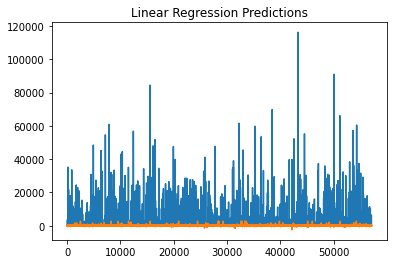

In [112]:
plt.title("Linear Regression Predictions")
plt.plot(range(57081), list(y_test), label='ground truth')
plt.plot(range(57081), list(y_predicted), label='Linear Regression')
plt.show()

### Random Forest

In [113]:
X_train = X_train[0:5000]
y_train = y_train[0:5000]

In [114]:
X_test = X_test[0:5000]
y_test = y_test[0:5000]

In [115]:
X_train.shape

(5000, 200)

In [116]:
y_train.shape

(5000,)

In [117]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

RandomForestRegressor()

In [118]:
y_predicted = randomforest.predict(X_test)
print(len(y_predicted))

5000


In [119]:
r2_and_rmse(y_predicted)

[-0.3371420845060311, 1765.47395836392]

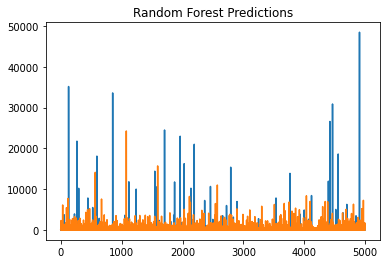

In [120]:
plt.title("Random Forest Predictions")
plt.plot(range(5000), list(y_test), label='ground truth')
plt.plot(range(5000), list(y_predicted), label='Random Forest')
plt.show()

### KNN 

In [121]:
knn_regression = KNeighborsRegressor()
knn_regression.fit(X_train, y_train)

KNeighborsRegressor()

In [122]:
y_predicted = knn_regression.predict(X_test)
print(len(y_predicted))

5000


In [123]:
r2_and_rmse(y_predicted)

[-0.2769968866585715, 1725.3112581305438]

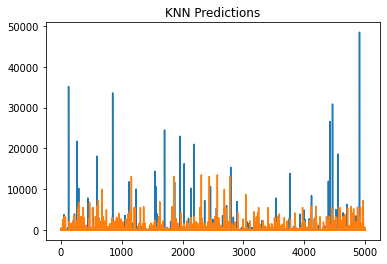

In [125]:
plt.title("KNN Predictions")
plt.plot(range(5000), list(y_test), label='ground truth')
plt.plot(range(5000), list(y_predicted), label='KNN')
plt.show()

### Neural Network

In [126]:
df.shape

(190853, 4)

In [129]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import nltk
import re
import nltk
nltk.download('stopwords')

words_to_remove = stopwords.words('english')

def tokenize(text):
    cleaned = [re.sub("[^a-zA-Z]", "", word) for word in text.lower().split() if not word in words_to_remove]
    cleaned = [word for word in cleaned if len(word)]
    return cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
X = df['title'][0:10000]
y = df['score'][0:10000]

real_text = X
metric_score = y

x_train_ex, x_test_ex, y_train_ex, y_test_ex = train_test_split(real_text, metric_score, test_size = 0.2, random_state = 79)

vectorizer = CountVectorizer(analyzer=tokenize, max_features = 1000).fit(X)

In [131]:
X = vectorizer.transform(X)

In [132]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(8000, 1000) (8000,) (2000, 1000) (2000,)


In [133]:
X_train = x_train[0:5000]
y_train = y_train[0:5000]

In [134]:
X_test = x_test[0:5000]
y_test = y_test[0:5000]

In [135]:
print(type(X_train))
X_train = X_train.toarray()
print(X_train)

<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [136]:
print(len(X_train))
print(len(X_train[0]))

5000
1000


In [137]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Conv1D, Dense, MaxPooling1D, Activation, Embedding, Dropout

nnmodel = Sequential()

nnmodel.add(Embedding(5000, 64, input_length=1000))

nnmodel.add(MaxPooling1D())

#nnmodel.add(Conv1D(filters = 32, kernel_size = (3),padding = 'Same',activation ='relu', input_shape = (1, 1000, 1)))
nnmodel.add(Dense(64))

nnmodel.add(Dropout(0.5))

#nnmodel.add(Conv1D(filters = 64, kernel_size = (3),padding = 'Same',activation ='relu'))

nnmodel.add(Flatten())
nnmodel.add(Dense(256))
nnmodel.add(Activation('relu'))
nnmodel.add(Dense(1, activation = "linear"))
    

nnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          320000    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 500, 64)          0         
 1D)                                                             
                                                                 
 dense_3 (Dense)             (None, 500, 64)           4160      
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8192256   
                                                      

In [138]:
nnmodel.compile(loss='MSE',
             optimizer='adam',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [139]:
history = nnmodel.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
157/157 [==============================] - 19s 119ms/step - loss: 2470461.7500 - root_mean_squared_error: 1571.7703
Epoch 2/10
157/157 [==============================] - 19s 121ms/step - loss: 2469699.0000 - root_mean_squared_error: 1571.5276
Epoch 3/10
157/157 [==============================] - 23s 148ms/step - loss: 2468941.5000 - root_mean_squared_error: 1571.2866
Epoch 4/10
157/157 [==============================] - 19s 120ms/step - loss: 2469440.5000 - root_mean_squared_error: 1571.4453
Epoch 5/10
157/157 [==============================] - 19s 124ms/step - loss: 2468269.2500 - root_mean_squared_error: 1571.0726
Epoch 6/10
157/157 [==============================] - 19s 123ms/step - loss: 2467124.0000 - root_mean_squared_error: 1570.7081
Epoch 7/10
157/157 [==============================] - 19s 121ms/step - loss: 2465377.0000 - root_mean_squared_error: 1570.1519
Epoch 8/10
157/157 [==============================] - 19s 121ms/step - loss: 2460616.7500 - root_mean_squared_e

Loss on last epoch:  2445277.75


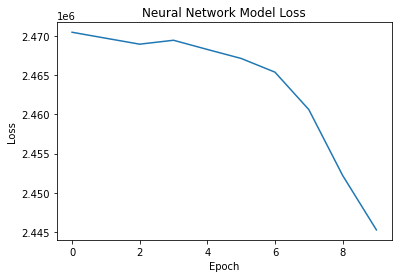

In [140]:
plt.title("Neural Network Model Loss")
plt.plot(history.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
print("Loss on last epoch: ", history.history['loss'][9])

In [141]:
X_test = X_test.toarray()
y_predicted = nnmodel.predict(X_test)

In [142]:
r2_and_rmse(y_predicted)

[-0.02312965282396684, 518.080429362082]

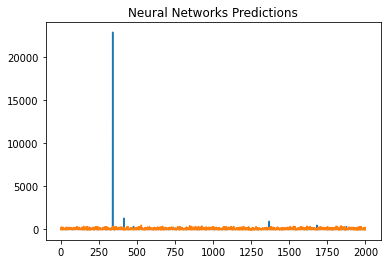

In [145]:
plt.title("Neural Networks Predictions")
plt.plot(range(2000), list(y_test), label='ground truth')
plt.plot(range(2000), list(y_predicted), label='Neural Network')
plt.show()

# **Part C: Additional preprocessing & dividing data**

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190853 entries, 0 to 190852
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         190853 non-null  object
 1   score         190853 non-null  int64 
 2   num_comments  190853 non-null  int64 
 3   vector        190853 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.8+ MB


In [148]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,190853.0,176.016159,1951.936524,0.0,1.0,1.0,4.0,116226.0
num_comments,190853.0,27.604732,213.236378,0.0,1.0,2.0,5.0,18801.0


In [149]:
len(df)

190853

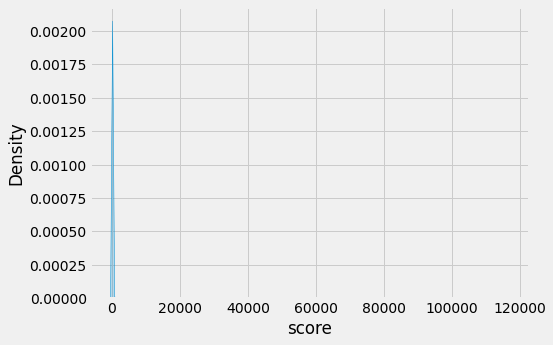

In [150]:
plt.figure(figsize=(7,5))

sns.kdeplot(df['score'], shade=  True)

In [151]:
data = df

In [152]:
print(len(data[data['score'] < 10]), 'Posts with less than 10 votes')
print(len(data[data['score'] > 10]), 'Posts with more than 10 votes')

159379 Posts with less than 10 votes
29881 Posts with more than 10 votes


## Preprocessing and dividing

In [153]:
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text 

In [154]:
data['clean_title'] = pd.Series([clean_text(i) for i in tqdm(data['title'])])

  0%|          | 0/190853 [00:00<?, ?it/s]

**Wordcloud**

In [155]:
words = data["clean_title"].values


In [156]:
ls = []

for i in words:
    ls.append(str(i))

In [157]:
ls[:5]

['wordcloud trend video titl youtub unit state  oc',
 'wordcloud trend video youtub unit state  ',
 'immun india sourc https nitigovincontentimmunis',
 'quick estim impact player basketbal game oc',
 'quick estim impact player basketbal game']

(-0.5, 1599.5, 799.5, -0.5)

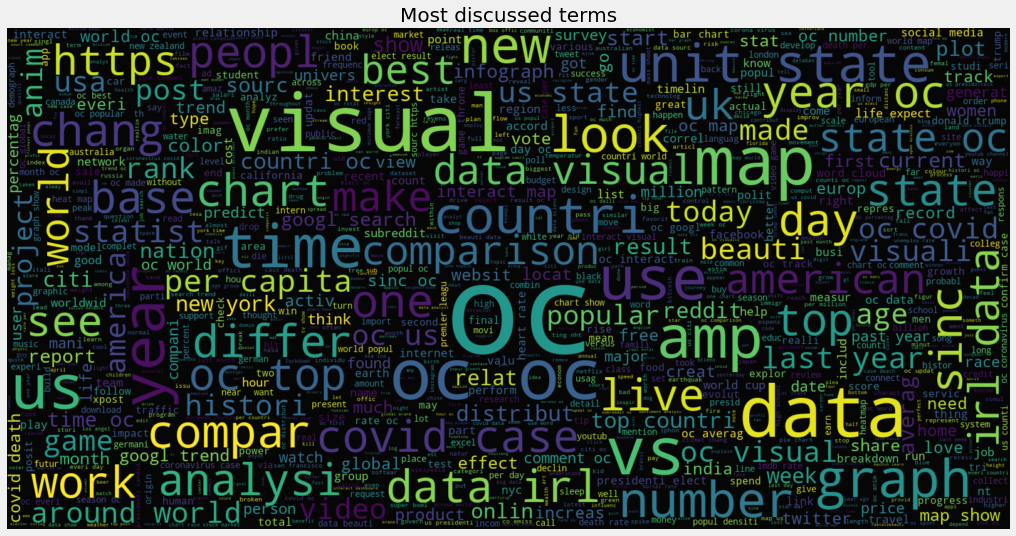

In [158]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

**Most popular posts**

In [159]:
most_pop = data.sort_values('score', ascending =False)[['title', 'score']].head(12)

most_pop['score1'] = most_pop['score']/1000

Text(0.5, 1.0, 'Most popular posts')

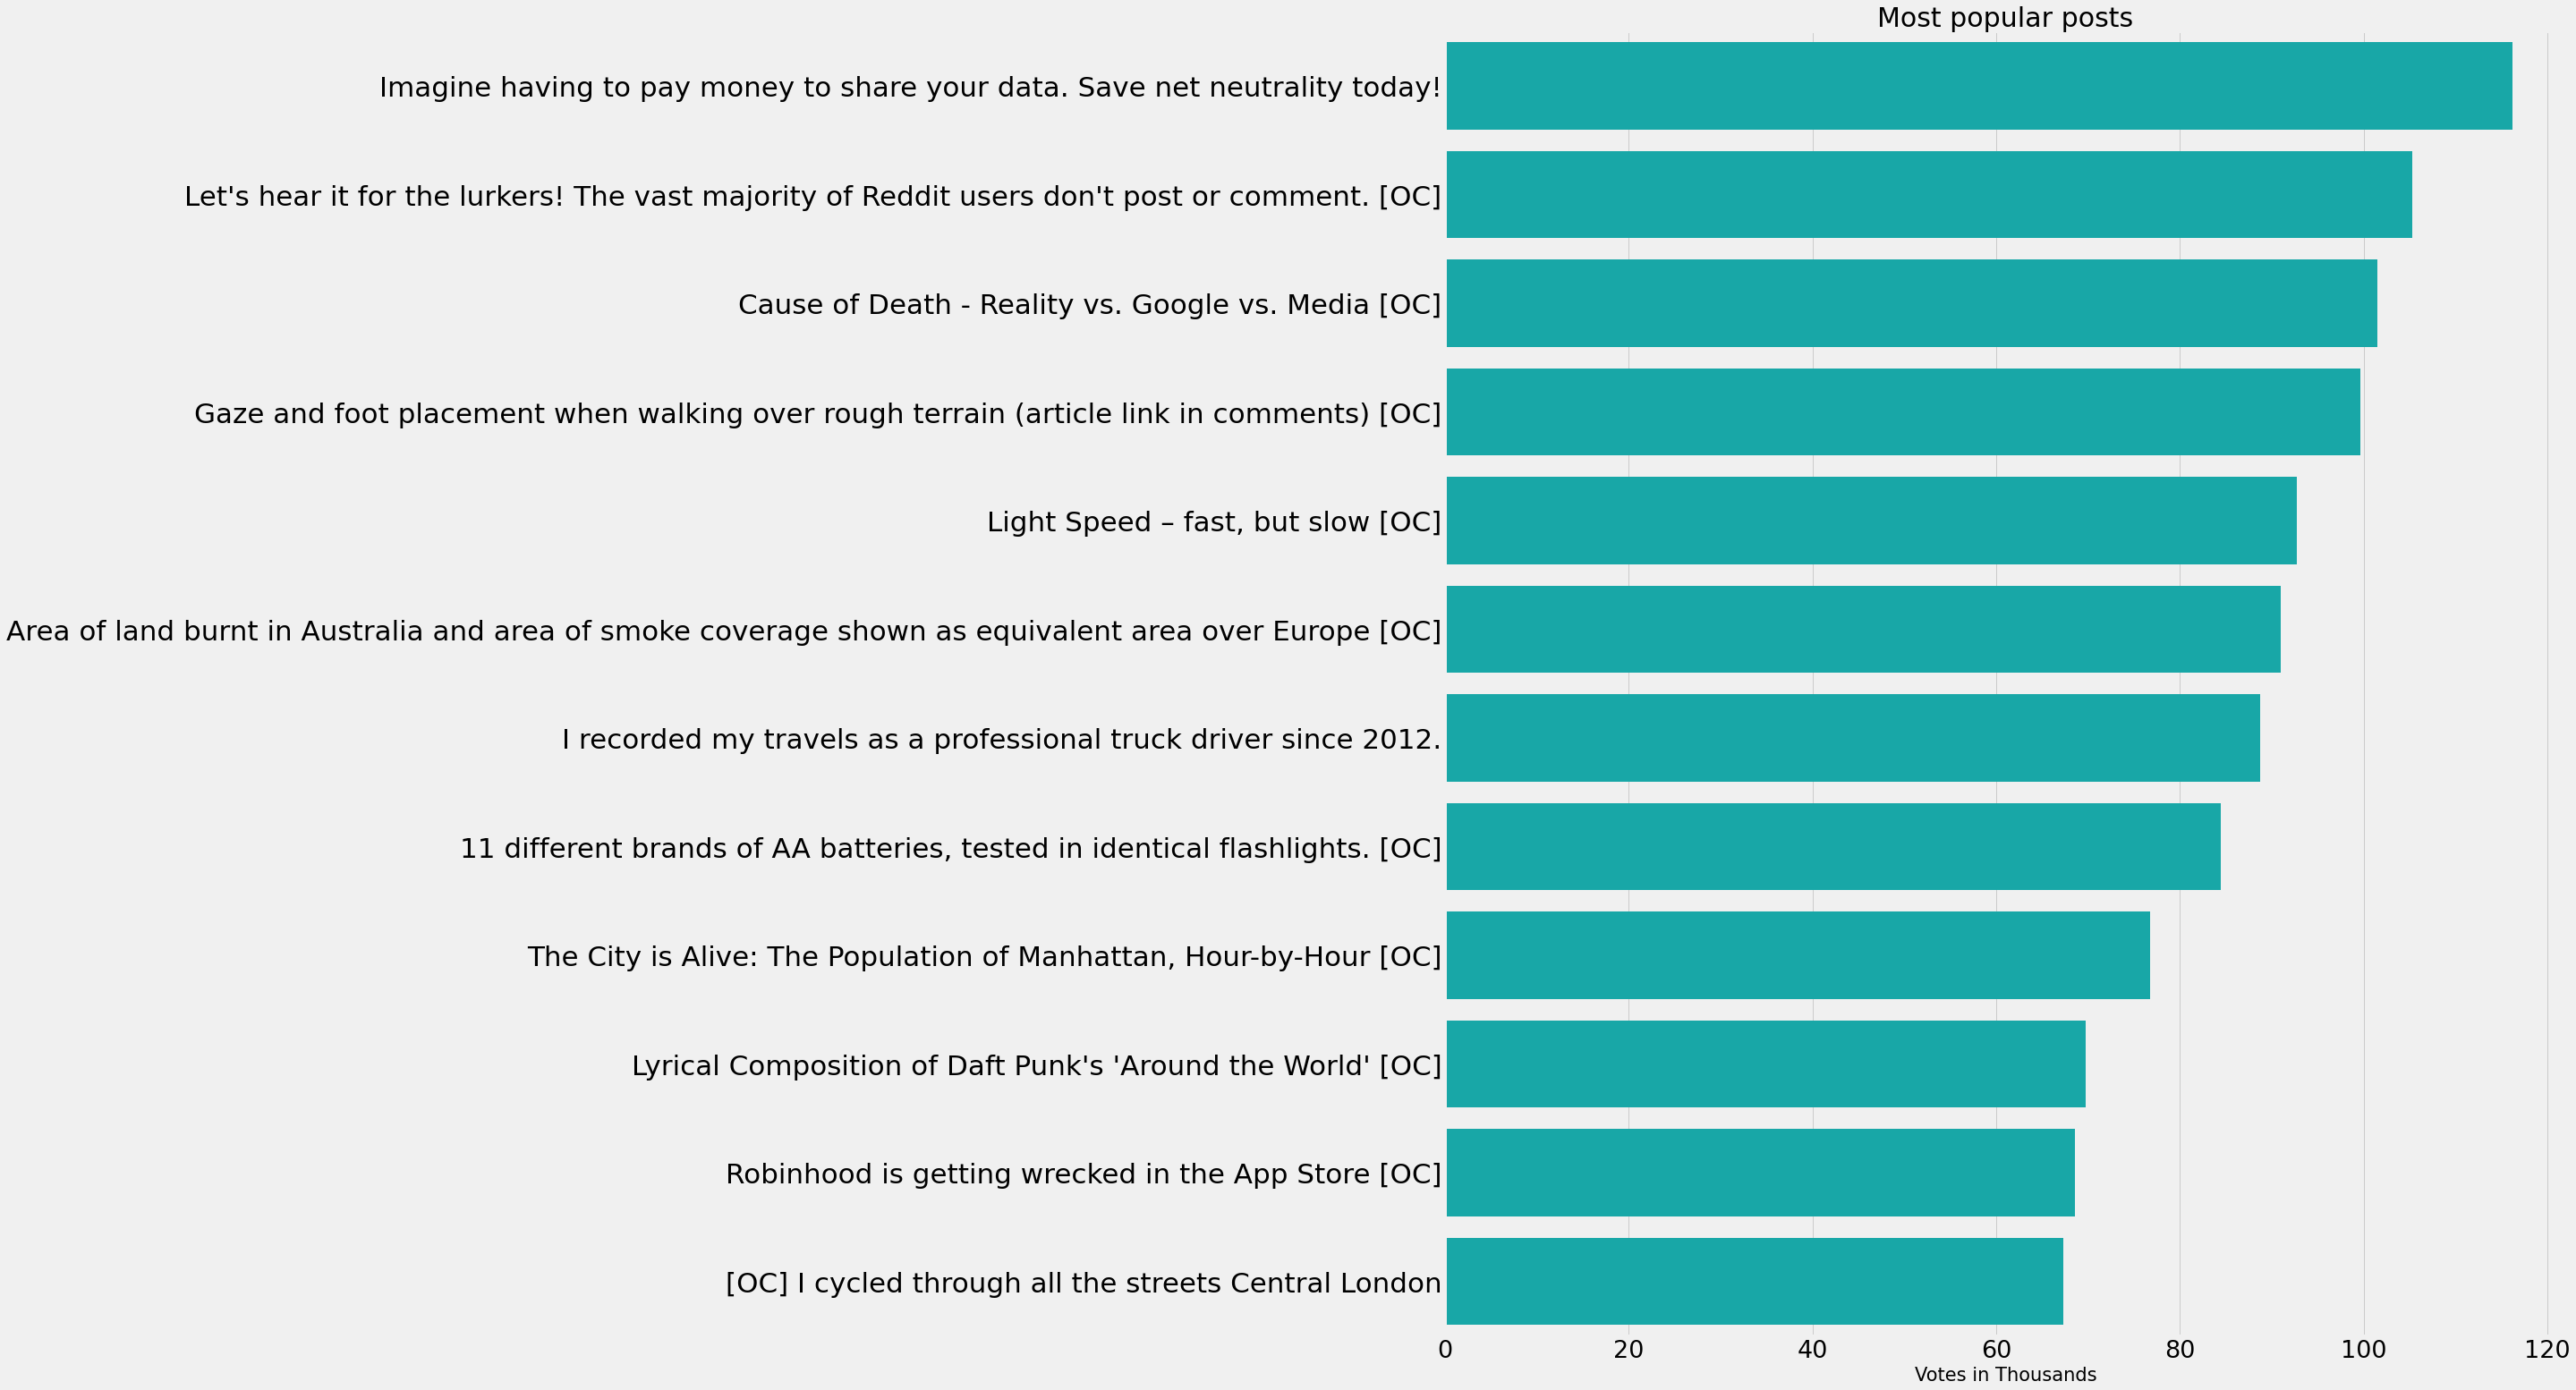

In [160]:
plt.figure(figsize = (20,25))

sns.barplot(data = most_pop, y = 'title', x = 'score1', color = 'c')
plt.xticks(fontsize=27, rotation=0)
plt.yticks(fontsize=31, rotation=0)
plt.xlabel('Votes in Thousands', fontsize = 21)
plt.ylabel('')
plt.title('Most popular posts', fontsize = 30)

**Lemmatization**

In [161]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [162]:
stemmer = SnowballStemmer('english')

In [163]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [164]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [165]:
lemmatized = data['title'].apply(preprocess)

In [166]:
lemmatized[0]

['wordcloud', 'trend', 'video', 'titl', 'youtub', 'unit', 'state']

**Dividing data**

In [167]:
df['score'][1000:1030]

1000     1
1001     1
1002     1
1003     1
1004     1
1005     1
1006     5
1007    13
1008     1
1009     1
1010     1
1011     2
1012     1
1013     9
1014     7
1015     1
1016     1
1017     1
1018     1
1019     1
1020     7
1021     1
1022     2
1023     8
1024     1
1025     0
1026     2
1027     0
1028     0
1029     1
Name: score, dtype: int64

In [168]:
test = df['score'][0:2000]
test

0        1
1        1
2        1
3        1
4        1
        ..
1995     1
1996     1
1997     1
1998    12
1999     1
Name: score, Length: 2000, dtype: int64

In [169]:
value = test

In [170]:
j=0
for i in test[0:2000]:
  if (i <= 2): 
    value[j]=1
  elif (i> 2 and i<=10):
    value[j]=2
  elif (i>10 and i<=50):
    value[j]=3
  elif (i>50 and i<=100):
    value[j]=4
  else:
    value[j]=5
  j= j+1


In [171]:
value[1000:1030]

1000    1
1001    1
1002    1
1003    1
1004    1
1005    1
1006    2
1007    3
1008    1
1009    1
1010    1
1011    1
1012    1
1013    2
1014    2
1015    1
1016    1
1017    1
1018    1
1019    1
1020    2
1021    1
1022    1
1023    2
1024    1
1025    1
1026    1
1027    1
1028    1
1029    1
Name: score, dtype: int64

2

**Prepare data**

In [172]:
X = lemmatized[0:2000]

In [173]:
y = value

In [174]:
X.shape

(2000,)

In [175]:
y.shape

(2000,)

In [176]:
newData = [X, y]

In [177]:
newData = df[0:2000]
newData

,title,score,num_comments,vector,clean_title
0,Wordcloud of trending video titles on YouTube ...,1,0,"[0.25498742, -0.13741137, 0.2540481, -0.038217...",wordcloud trend video titl youtub unit state oc
1,Wordcloud of trending videos on YouTube in the...,1,1,"[0.27569857, -0.12842587, 0.26410136, -0.01331...",wordcloud trend video youtub unit state
2,Immunization in India. Source: https://niti.go...,1,1,"[0.22899331, -0.025959194, 0.13093157, -0.0257...",immun india sourc https nitigovincontentimmunis
3,How to quickly estimate the impact of players ...,1,0,"[0.21554905, -0.13485904, 0.18067668, -0.05638...",quick estim impact player basketbal game oc
4,How to quickly estimate the impact of players ...,1,2,"[0.22416717, -0.125399, 0.1786206, -0.03527394...",quick estim impact player basketbal game
...,...,...,...,...,...
1995,"Tracked all the movies I watched in 2020, sort...",1,2,"[0.26116654, -0.26552156, 0.24662092, -0.00696...",track movi watch sort seen seen
1996,Trans-Atlantic Slave Trade statistics,1,2,"[0.22686651, -0.034621663, 0.1564393, -0.01053...",transatlant slave trade statist
1997,Scandinavia 2010-2020 deaths normalized to 201...,1,2,"[0.23693639, -0.03558567, 0.2506449, 0.0629259...",scandinavia death normal averag
1998,LEGO Themes Brick Color Distribution [OC],3,248,"[0.2610808, -0.19743039, 0.19730106, -0.113244...",lego theme brick color distribut oc


In [178]:
newData['title'] = lemmatized[0:2000]
newData['score'] = value[0:2000]
newData

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,score,num_comments,vector,clean_title
0,"[wordcloud, trend, video, titl, youtub, unit, ...",1,0,"[0.25498742, -0.13741137, 0.2540481, -0.038217...",wordcloud trend video titl youtub unit state oc
1,"[wordcloud, trend, video, youtub, unit, state]",1,1,"[0.27569857, -0.12842587, 0.26410136, -0.01331...",wordcloud trend video youtub unit state
2,"[immun, india, sourc, https, niti, content, im...",1,1,"[0.22899331, -0.025959194, 0.13093157, -0.0257...",immun india sourc https nitigovincontentimmunis
3,"[quick, estim, impact, player, basketbal, game]",1,0,"[0.21554905, -0.13485904, 0.18067668, -0.05638...",quick estim impact player basketbal game oc
4,"[quick, estim, impact, player, basketbal, game]",1,2,"[0.22416717, -0.125399, 0.1786206, -0.03527394...",quick estim impact player basketbal game
...,...,...,...,...,...
1995,"[track, movi, watch, sort, see, see]",1,2,"[0.26116654, -0.26552156, 0.24662092, -0.00696...",track movi watch sort seen seen
1996,"[tran, atlant, slave, trade, statist]",1,2,"[0.22686651, -0.034621663, 0.1564393, -0.01053...",transatlant slave trade statist
1997,"[scandinavia, death, normal, averag]",1,2,"[0.23693639, -0.03558567, 0.2506449, 0.0629259...",scandinavia death normal averag
1998,"[lego, theme, brick, color, distribut]",3,248,"[0.2610808, -0.19743039, 0.19730106, -0.113244...",lego theme brick color distribut oc


## Pre-trained Word2vec

Load pre-trained word2vec model (Google News model from https://github.com/3Top/word2vec-api)

In [179]:
pretrained_w2v.wv.most_similar(positive=["music"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('songs', 0.7505496144294739),
 ('song', 0.7471686601638794),
 ('listen', 0.7370840311050415),
 ('listening', 0.7022502422332764),
 ('radio', 0.6813289523124695),
 ('album', 0.6802948117256165),
 ('rap', 0.6734380722045898),
 ('tunes', 0.6719679832458496),
 ('pop', 0.6593461036682129),
 ('new', 0.6564810872077942)]

In [ ]:
pretrained_w2v.wv.most_similar(positive=["bad"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('good', 0.7983508110046387),
 ('but', 0.7916753888130188),
 ('shit', 0.7843010425567627),
 ('really', 0.7759409546852112),
 ("n't", 0.7675077319145203),
 ('damn', 0.7660024166107178),
 ('think', 0.7650412321090698),
 ('that', 0.7635563015937805),
 ('it', 0.7619757056236267),
 ('thing', 0.7606295347213745)]

In [ ]:
pretrained_w2v.wv.most_similar(positive=["fun"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('awesome', 0.7480978965759277),
 ('great', 0.7329563498497009),
 ('enjoy', 0.732480525970459),
 ('night', 0.7296019196510315),
 ('weekend', 0.7253780364990234),
 ('friends', 0.7195812463760376),
 ('good', 0.7155195474624634),
 ('too', 0.7111462950706482),
 ('cool', 0.7105849981307983),
 ('going', 0.704038143157959)]

In [180]:
pretrained_w2v.vector_size

200

In [181]:
pretrained_w2v.wv.vocab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


{'<user>': <gensim.models.keyedvectors.Vocab at 0x7f31f16a9e50>,
 '.': <gensim.models.keyedvectors.Vocab at 0x7f31f1764b50>,
 ':': <gensim.models.keyedvectors.Vocab at 0x7f31f16a97d0>,
 'rt': <gensim.models.keyedvectors.Vocab at 0x7f31f1747dd0>,
 ',': <gensim.models.keyedvectors.Vocab at 0x7f31f17d4390>,
 '<repeat>': <gensim.models.keyedvectors.Vocab at 0x7f31f177d290>,
 '<hashtag>': <gensim.models.keyedvectors.Vocab at 0x7f31f17740d0>,
 '<number>': <gensim.models.keyedvectors.Vocab at 0x7f31f1603110>,
 '<url>': <gensim.models.keyedvectors.Vocab at 0x7f31f1774110>,
 '!': <gensim.models.keyedvectors.Vocab at 0x7f31f16034d0>,
 'i': <gensim.models.keyedvectors.Vocab at 0x7f31eff49750>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7f31f1603ed0>,
 '"': <gensim.models.keyedvectors.Vocab at 0x7f31f1774f10>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f31f1603fd0>,
 '?': <gensim.models.keyedvectors.Vocab at 0x7f31f1774b90>,
 'you': <gensim.models.keyedvectors.Vocab at 0x7f31f1603350>,
 'to

In [182]:
#calculating average word2vec
def get_avg_vec(words):
  # remove out-of-vocabulary words
  words = [word for word in words if word in pretrained_w2v.wv.vocab]
  if len(words) >= 1:
      return np.mean(pretrained_w2v[words], axis=0)
  else:
      return []

In [183]:
df = newData

In [184]:
df

,title,score,num_comments,vector,clean_title
0,"[wordcloud, trend, video, titl, youtub, unit, ...",1,0,"[0.25498742, -0.13741137, 0.2540481, -0.038217...",wordcloud trend video titl youtub unit state oc
1,"[wordcloud, trend, video, youtub, unit, state]",1,1,"[0.27569857, -0.12842587, 0.26410136, -0.01331...",wordcloud trend video youtub unit state
2,"[immun, india, sourc, https, niti, content, im...",1,1,"[0.22899331, -0.025959194, 0.13093157, -0.0257...",immun india sourc https nitigovincontentimmunis
3,"[quick, estim, impact, player, basketbal, game]",1,0,"[0.21554905, -0.13485904, 0.18067668, -0.05638...",quick estim impact player basketbal game oc
4,"[quick, estim, impact, player, basketbal, game]",1,2,"[0.22416717, -0.125399, 0.1786206, -0.03527394...",quick estim impact player basketbal game
...,...,...,...,...,...
1995,"[track, movi, watch, sort, see, see]",1,2,"[0.26116654, -0.26552156, 0.24662092, -0.00696...",track movi watch sort seen seen
1996,"[tran, atlant, slave, trade, statist]",1,2,"[0.22686651, -0.034621663, 0.1564393, -0.01053...",transatlant slave trade statist
1997,"[scandinavia, death, normal, averag]",1,2,"[0.23693639, -0.03558567, 0.2506449, 0.0629259...",scandinavia death normal averag
1998,"[lego, theme, brick, color, distribut]",3,248,"[0.2610808, -0.19743039, 0.19730106, -0.113244...",lego theme brick color distribut oc


In [185]:
df['title'][0]

['wordcloud', 'trend', 'video', 'titl', 'youtub', 'unit', 'state']

In [186]:
df['vector'] = df['title'].apply(get_avg_vec)
df['vector'][1].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(200,)

In [187]:
data = df
data

,title,score,num_comments,vector,clean_title
0,"[wordcloud, trend, video, titl, youtub, unit, ...",1,0,"[0.06785785, 0.20211999, -0.21228385, -0.37989...",wordcloud trend video titl youtub unit state oc
1,"[wordcloud, trend, video, youtub, unit, state]",1,1,"[0.09954083, 0.21172833, -0.22176284, -0.46153...",wordcloud trend video youtub unit state
2,"[immun, india, sourc, https, niti, content, im...",1,1,"[0.125976, 0.10248248, -0.26735958, 0.16109613...",immun india sourc https nitigovincontentimmunis
3,"[quick, estim, impact, player, basketbal, game]",1,0,"[0.015697336, 0.49355817, -0.07892832, -0.4427...",quick estim impact player basketbal game oc
4,"[quick, estim, impact, player, basketbal, game]",1,2,"[0.015697336, 0.49355817, -0.07892832, -0.4427...",quick estim impact player basketbal game
...,...,...,...,...,...
1995,"[track, movi, watch, sort, see, see]",1,2,"[0.21612668, 0.56954354, -0.12385833, -0.24368...",track movi watch sort seen seen
1996,"[tran, atlant, slave, trade, statist]",1,2,"[0.18168402, -0.053424604, 0.139722, -0.009643...",transatlant slave trade statist
1997,"[scandinavia, death, normal, averag]",1,2,"[-0.0670425, -0.1268425, 0.04350125, 0.2871425...",scandinavia death normal averag
1998,"[lego, theme, brick, color, distribut]",3,248,"[0.21483248, -0.17310575, -0.21467543, 0.34321...",lego theme brick color distribut oc


In [188]:
data.shape

(2000, 5)

In [189]:
df['vector'][1]

array([ 9.95408297e-02,  2.11728334e-01, -2.21762836e-01, -4.61536735e-01,
        2.07232356e-01, -3.50597024e-01,  2.58129328e-01, -2.16583669e-01,
        5.83061688e-02, -1.53860003e-01, -3.64443362e-02,  1.68069992e-02,
       -3.24935645e-01,  3.31403315e-02,  2.56581664e-01, -1.82651654e-01,
        5.34754507e-02,  1.39448307e-02,  5.14525063e-02,  1.42817661e-01,
       -8.97789970e-02,  6.13896661e-02, -9.70179960e-02,  6.58283308e-02,
       -5.49365819e-01,  3.20235014e-01, -1.07686318e-01,  8.25295076e-02,
       -2.14524567e-01,  3.59388329e-02,  3.17797005e-01, -2.29238316e-01,
        1.23563342e-01, -4.31671627e-02,  5.60356677e-01, -2.12530151e-01,
        2.54669160e-01, -1.96349993e-03,  6.41200021e-02, -1.02006674e-01,
        9.50636640e-02,  4.89143319e-02, -1.56338334e-01,  9.74850059e-02,
        1.80845007e-01,  3.41871142e-01, -2.67179996e-01, -2.47373298e-01,
       -2.63785005e-01, -2.01678857e-01, -5.37383370e-02,  5.70290051e-02,
        2.42861509e-01,  

##***Train-test split***

In [193]:
data['score'] = df['score'].astype(int)
data = df[df['vector'].map(len) == 200]

data

,title,score,num_comments,vector,clean_title
0,"[wordcloud, trend, video, titl, youtub, unit, ...",1,0,"[0.06785785, 0.20211999, -0.21228385, -0.37989...",wordcloud trend video titl youtub unit state oc
1,"[wordcloud, trend, video, youtub, unit, state]",1,1,"[0.09954083, 0.21172833, -0.22176284, -0.46153...",wordcloud trend video youtub unit state
2,"[immun, india, sourc, https, niti, content, im...",1,1,"[0.125976, 0.10248248, -0.26735958, 0.16109613...",immun india sourc https nitigovincontentimmunis
3,"[quick, estim, impact, player, basketbal, game]",1,0,"[0.015697336, 0.49355817, -0.07892832, -0.4427...",quick estim impact player basketbal game oc
4,"[quick, estim, impact, player, basketbal, game]",1,2,"[0.015697336, 0.49355817, -0.07892832, -0.4427...",quick estim impact player basketbal game
...,...,...,...,...,...
1995,"[track, movi, watch, sort, see, see]",1,2,"[0.21612668, 0.56954354, -0.12385833, -0.24368...",track movi watch sort seen seen
1996,"[tran, atlant, slave, trade, statist]",1,2,"[0.18168402, -0.053424604, 0.139722, -0.009643...",transatlant slave trade statist
1997,"[scandinavia, death, normal, averag]",1,2,"[-0.0670425, -0.1268425, 0.04350125, 0.2871425...",scandinavia death normal averag
1998,"[lego, theme, brick, color, distribut]",3,248,"[0.21483248, -0.17310575, -0.21467543, 0.34321...",lego theme brick color distribut oc


In [194]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3)

train

,title,score,num_comments,vector,clean_title
822,"[food, trend]",1,4,"[-0.06353, -0.003729999, -0.0018799901, -0.494...",oc food trend
254,"[sea, port]",1,2,"[-0.830955, -0.20932999, 0.35402, 0.284805, -0...",eth sea port oc
720,"[indian, budget]",4,38,"[-0.113055, -0.25090498, -0.1313695, 0.2809035...",indian budget oc
1267,"[differ, winter, averag, citi, year]",1,2,"[-0.10511999, -0.070957996, 0.032498002, 0.089...",differ winter averag citi year
572,"[poll, number, democrat, primari, candid]",1,6,"[0.30770752, 0.16949801, -0.35156974, -0.16163...",poll number democrat primari candid oc
...,...,...,...,...,...
921,"[remix, comparison, word, democrat, republican...",1,39,"[0.21714668, 0.359532, -0.18779582, 0.21984667...",oc remix comparison word use democrat republic...
780,"[week, death, excess, death]",3,15,"[0.22124325, -0.20798126, -0.2152875, 0.063515...",us cdc week death mar st jan th k excess de...
227,"[profit, pink, money, blue, pay, subcontractor...",1,0,"[-0.086615376, -0.0072292364, -0.074907005, -0...",would show profit pink money made blue paid su...
617,"[groundhog, result, major, groundhog, favour, ...",1,2,"[-0.05106571, -0.00720872, -0.28149387, 0.1421...",groundhog day result major groundhog favour e...


In [195]:
X_train = np.array(train['vector'].tolist())
y_train = np.array(train['score'])

X_test = np.array(test['vector'].tolist())
y_test = np.array(test['score'])

In [196]:
y_train.shape

(1389,)

##**Modeling**

In [197]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

model_performance_dict = dict()

In [198]:
def r2_and_rmse(y_predicted):
    return [r2_score(y_test, y_predicted),np.sqrt(mean_squared_error(y_test, y_predicted))]

In [199]:
%%time
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

CPU times: user 308 µs, sys: 11 µs, total: 319 µs
Wall time: 326 µs


### Linear Regression

In [200]:
%%time
linear = LinearRegression()
linear.fit(X_train,y_train)

CPU times: user 32.1 ms, sys: 23.9 ms, total: 56 ms
Wall time: 40.4 ms


In [201]:
y_predicted = linear.predict(X_test)
print(len(y_predicted))

596


In [202]:
r2_and_rmse(y_predicted)

[-0.20553273651638726, 0.7353303342547517]

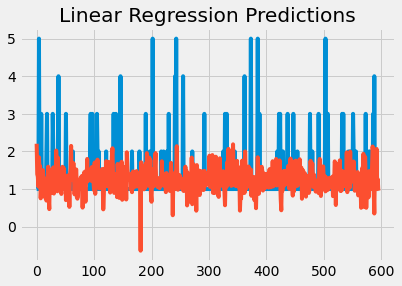

In [207]:
plt.title("Linear Regression Predictions")
plt.plot(range(596), list(y_test), label='ground truth')
plt.plot(range(596), list(y_predicted), label='Linear Regression')
plt.show()

### Random Forest

In [208]:
X_train = X_train[0:5000]
y_train = y_train[0:5000]

In [209]:
X_test = X_test[0:5000]
y_test = y_test[0:5000]

In [210]:
X_train.shape

(1389, 200)

In [211]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

RandomForestRegressor()

In [212]:
y_predicted = randomforest.predict(X_test)
print(len(y_predicted))

596


In [213]:
r2_and_rmse(y_predicted)

[-0.36468800734330453, 0.7823654538911419]

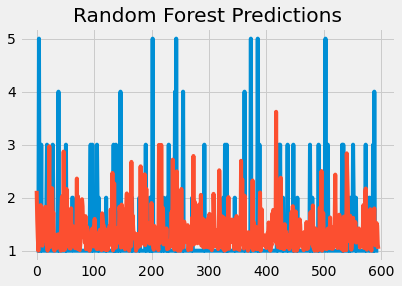

In [214]:
plt.title("Random Forest Predictions")
plt.plot(range(596), list(y_test), label='ground truth')
plt.plot(range(596), list(y_predicted), label='Random Forest')
plt.show()

### KNN 

In [215]:
knn_regression = KNeighborsRegressor()
knn_regression.fit(X_train, y_train)

KNeighborsRegressor()

In [216]:
y_predicted = knn_regression.predict(X_test)
print(len(y_predicted))

596


In [217]:
r2_and_rmse(y_predicted)

[-0.24614474997332492, 0.7476136532304933]

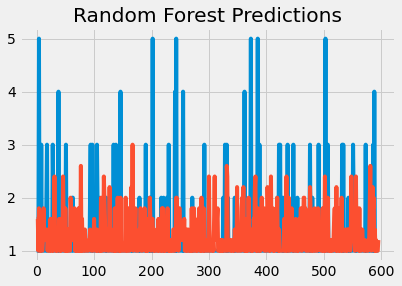

In [218]:
plt.title("Random Forest Predictions")
plt.plot(range(596), list(y_test), label='ground truth')
plt.plot(range(596), list(y_predicted), label='Random Forest')
plt.show()